# Examen 3

Para el desarrollo del tercer examen, usar los datos del archivo “Ex_1” para las preguntas del 01 al 03, mientras que para las preguntas 04 al 06 usar el archivo usar el archivo “Ex_2”, mientras que para las preguntas 07 y 08 usar el archivo “Ex_3”. Finalmente, para las preguntas 09 y 10 se va modificar el script del ejercicio de la Sesión 04 del Módulo 06, simular el modelo modificando el umbral de los coeficiente rugosidad, (umbral mínimo 0.06 y umbral máximo 0.08) para las llanuras izquierda y derecha.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio
import geopandas as gpd

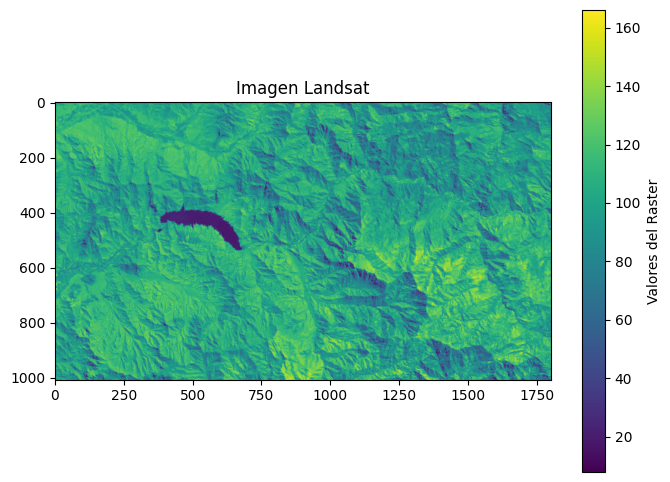

In [2]:
# 1. Obtener una gráfica que muestre el raster con una leyenda que indique el rango de los valores.
img1 = rasterio.open('./Data Examen 3/Ex_1/Rst/landsatImage.tif')
from rasterio import plot

# Leer la primera banda
band1 = img1.read(1)  # Leer la primera banda del raster

# Crear la figura
fig, ax = plt.subplots(figsize=(8,6))

# Mostrar el raster con color 'viridis' y barra de color
img_plot = ax.imshow(band1, cmap="viridis")  # Mostrar la imagen
plt.colorbar(img_plot, ax=ax, label="Valores del Raster")  # Agregar barra de color

# Agregar título
plt.title("Imagen Landsat")

# Mostrar el gráfico
plt.show()


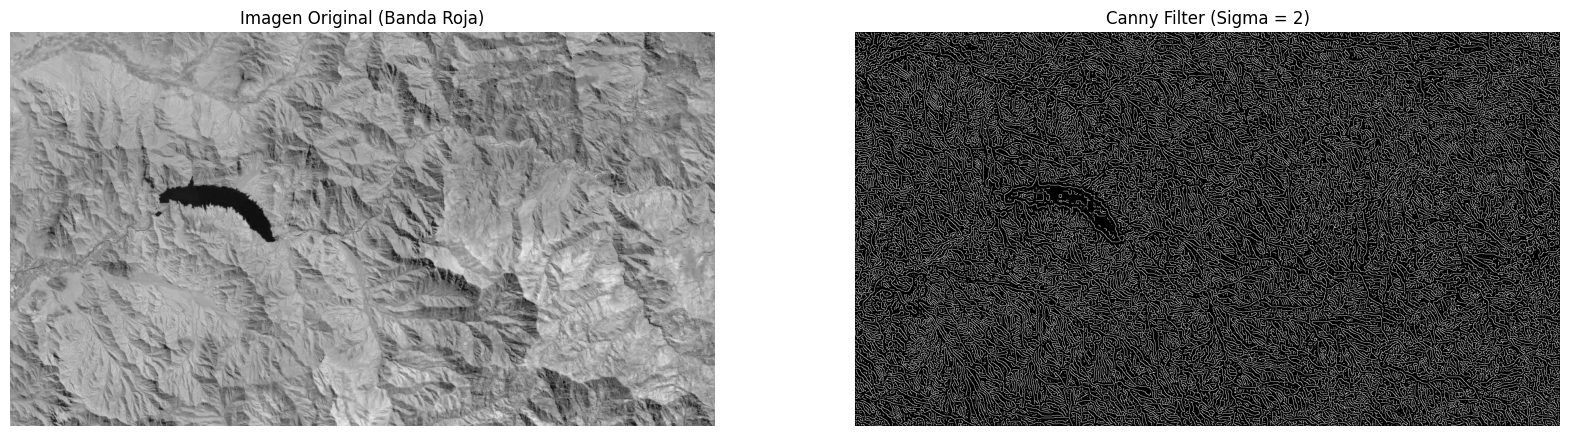

In [ ]:
# 2. Obtener gráficas usando Canny filter con 02 valores de sigma.
from skimage import feature
redBand, greenBand, blueBand = img1.read(1), img1.read(2), img1.read(3)
redBand = np.float32(redBand)
greenBand = np.float32(greenBand)
blueBand = np.float32(blueBand)

# Aplicar filtro de Canny con dos valores de sigma
edges_02_sigma = feature.canny(redBand, sigma=2)  # Sigma bajo

# Crear una figura con subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Mostrar imagen original
axes[0].imshow(redBand, cmap=plt.cm.gray)
axes[0].set_title('Imagen Original (Banda Roja)')
axes[0].axis('off')

# Mostrar imagen con Canny (sigma bajo)
axes[1].imshow(edges_02_sigma, cmap=plt.cm.gray)
axes[1].set_title('Canny Filter (Sigma = 2)')
axes[1].axis('off')

plt.show()

Red Band Stats: 8.0 166.0 99.69406


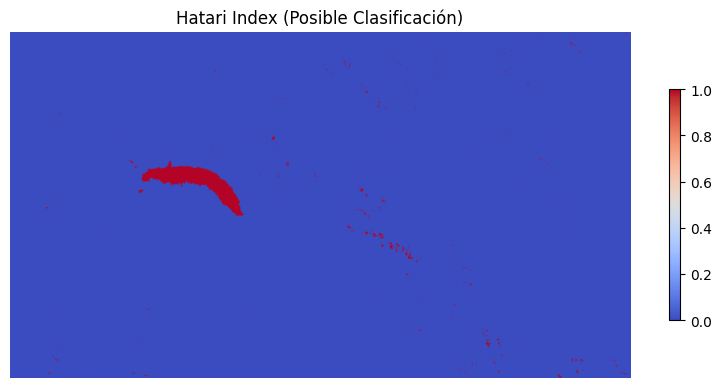

In [ ]:
print("Red Band Stats:", np.min(redBand), np.max(redBand), np.mean(redBand))
redFalse = np.zeros(redBand.shape)
redFalse[redBand < 30] = 1

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(redFalse, cmap='coolwarm')  # Mapa de colores para visualización
plt.colorbar(im, shrink=0.5)
plt.title("Hatari Index (Posible Clasificación)")
plt.axis('off')
plt.show()


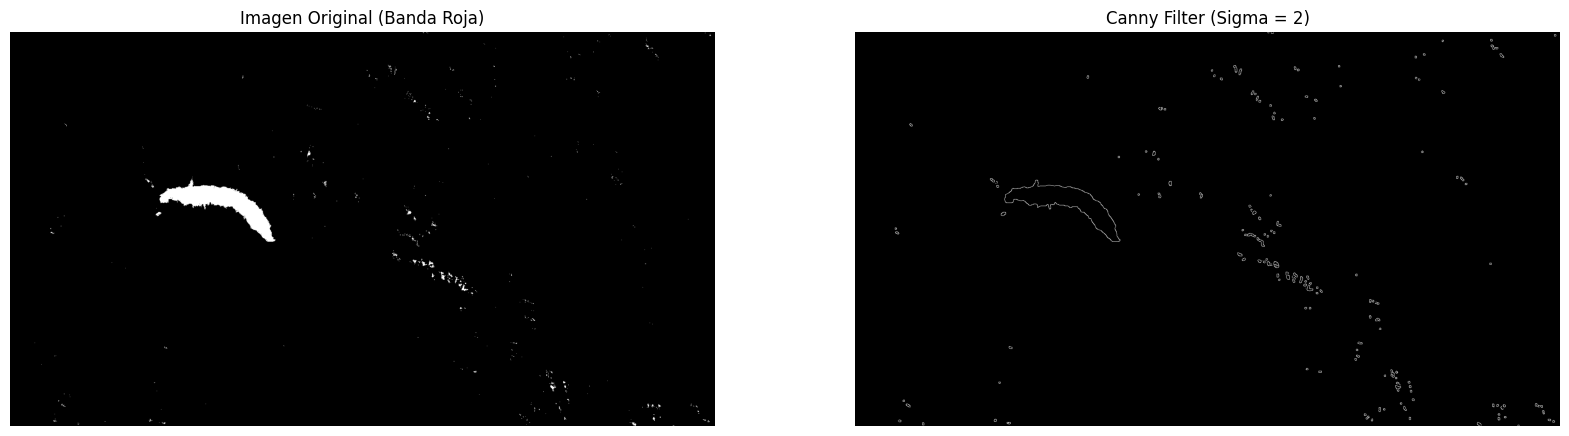

In [ ]:
# Aplicar filtro de Canny con dos valores de sigma
edges_02_sigma = feature.canny(redFalse, sigma=2)  # Sigma bajo

# Crear una figura con subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Mostrar imagen original
axes[0].imshow(redFalse, cmap=plt.cm.gray)
axes[0].set_title('Imagen Original (Banda Roja)')
axes[0].axis('off')

# Mostrar imagen con Canny (sigma bajo)
axes[1].imshow(edges_02_sigma, cmap=plt.cm.gray)
axes[1].set_title('Canny Filter (Sigma = 2)')
axes[1].axis('off')

plt.show()

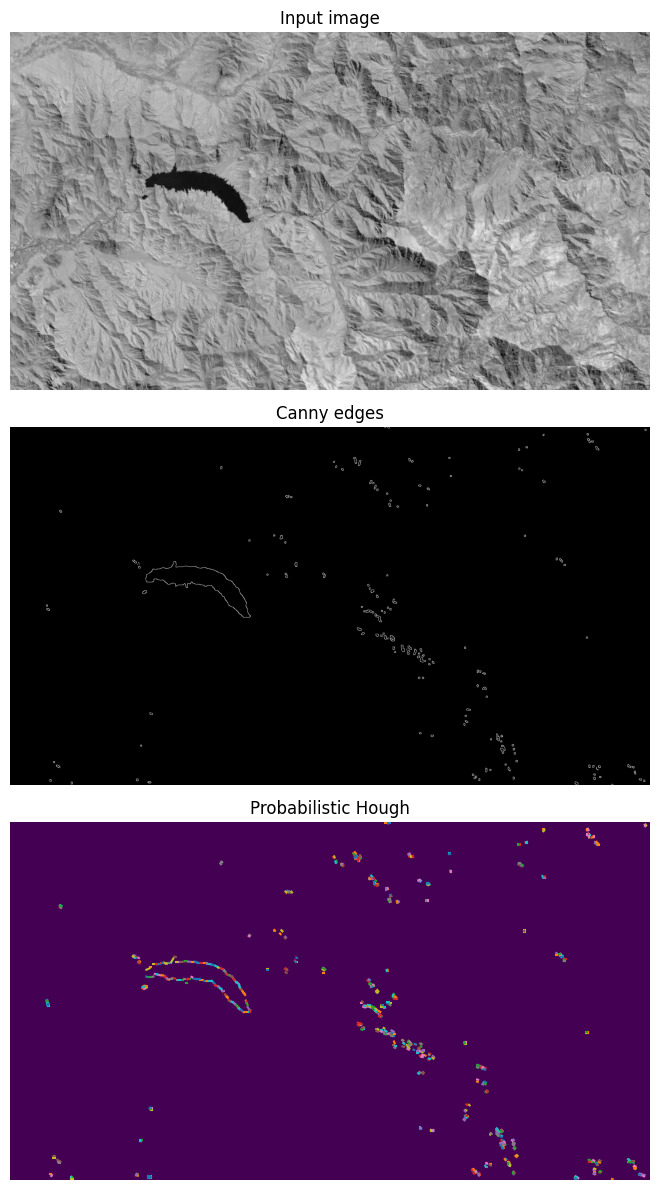

In [ ]:
# 3. Obtener una gráfica que muestra la delimitación del cuerpo de agua.
from skimage.transform import probabilistic_hough_line
from matplotlib import cm 
lines = probabilistic_hough_line(edges_02_sigma, threshold=2, line_length=2, line_gap=1)
# Generating figure 2  
fig, axes = plt.subplots(3, 1, figsize=(18, 12), sharex=True,  sharey=True)  
ax = axes.ravel()     
ax[0].imshow(redBand, cmap=cm.gray)  
ax[0].set_title('Input image')     
ax[1].imshow(edges_02_sigma, cmap=cm.gray)  
ax[1].set_title('Canny edges')    
ax[2].imshow(edges_02_sigma * 0)  
for line in lines:      
  p0, p1 = line      
  ax[2].plot((p0[0], p1[0]), (p0[1], p1[1])) 
ax[2].set_xlim((0, redBand.shape[1]))  
ax[2].set_ylim((redBand.shape[0], 0))  
ax[2].set_title('Probabilistic Hough')     
for a in ax:      
  a.set_axis_off()     
plt.tight_layout()
plt.show()  

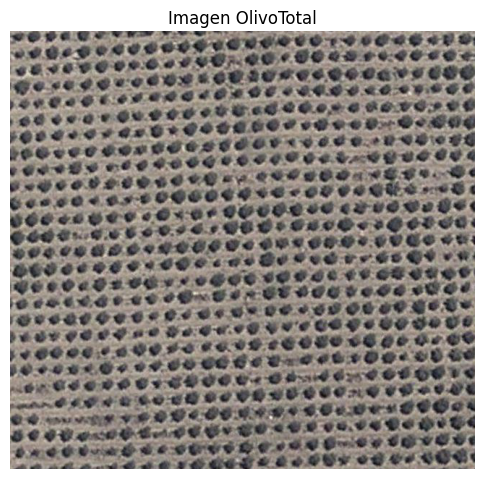

In [ ]:
# 4. Obtener una gráfica de la imagen total (OlivoTotal)..

from PIL import Image
from sklearn.cluster import Birch

# Se carga la imagen con PIL, al no poder usar rasterio por el formato
image_path = './Data Examen 3/Ex_2/OlivoTotal.png'
image = Image.open(image_path)

# Convertir la imagen a un array de numpy
image_array = np.array(image)

# Se grafica la imagen
plt.figure(figsize=(6, 6))
plt.imshow(image_array)
plt.title("Imagen OlivoTotal")
plt.axis("off")
plt.show()


Gray Image Stats: 1 249 120.77359741912265


Text(0.5, 1.0, 'Imagen OlivoTotal en Escala de Grises')

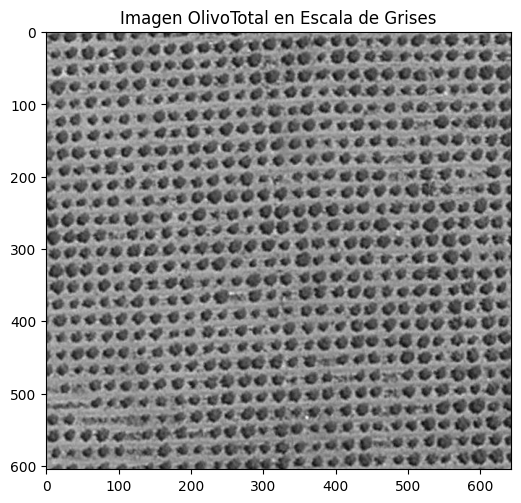

In [ ]:
# 5. Representación mediante una gráfica de los puntos cluster luego de Birch.

# Se convierte la imagen a escala de grises para extraer puntos más fácilmente
gray_image = image.convert("L")
gray_array = np.array(gray_image)

# Se describe los valores medio, maximos y minimos de la imagen
print("Gray Image Stats:", np.min(gray_array), np.max(gray_array), np.mean(gray_array))
plt.figure(figsize=(6, 6))
plt.imshow(gray_array, cmap="gray")
plt.title("Imagen OlivoTotal en Escala de Grises")


In [ ]:
# Se obtienen las coordenadas de los puntos que cumplen con el umbral, 3/4 de la media de la imagen

threshold = np.mean(gray_array) * 0.75
y_coords, x_coords = np.where(gray_array < threshold)
points = np.column_stack((x_coords, y_coords))  # Coordenadas X, Y

# Aplicar clustering Birch
birch = Birch(branching_factor=10000, n_clusters=None, threshold=2e-5, compute_labels=True)
birch.fit(points)
birchPoint = birch.subcluster_centers_


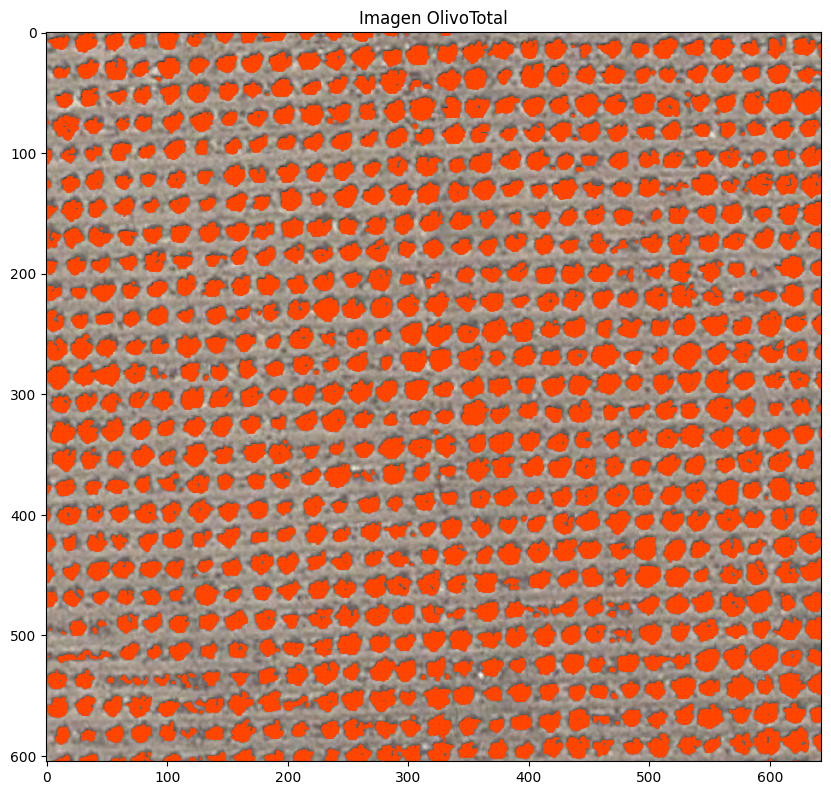

In [ ]:
# plot clustered points
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(birchPoint[:,[0]],birchPoint[:,[1]], marker='o',color='orangered',s=1)
plt.imshow(image_array)
plt.title("Imagen OlivoTotal")
plt.show()

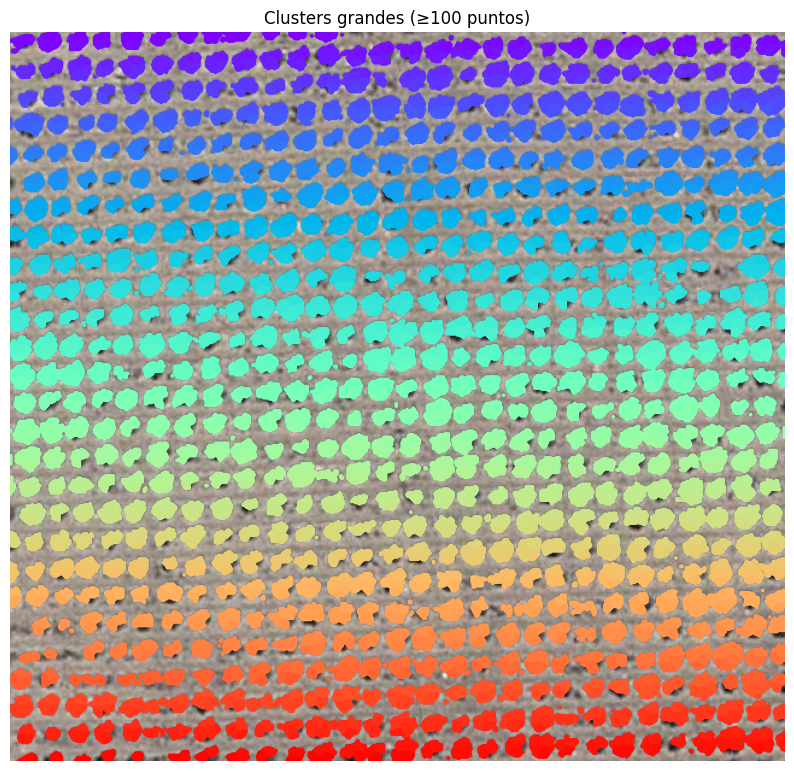

In [ ]:
from collections import Counter

threshold = 110
y_coords, x_coords = np.where(gray_array < threshold)
points = np.column_stack((x_coords, y_coords))

# Aumentamos el threshold de Birch para agrupar más puntos por cluster
birch = Birch(branching_factor=10000, n_clusters=None, threshold=4.0, compute_labels=True)
birch.fit(points)

labels = birch.labels_
label_counts = Counter(labels)


# Vamos a filtrar clusters con al menos 100 puntos
min_points = 35
filtered_indices = [i for i, lbl in enumerate(labels) if label_counts[lbl] >= min_points]
filtered_points = points[filtered_indices]
filtered_labels = [labels[i] for i in filtered_indices]

plt.figure(figsize=(10, 10))
plt.imshow(image_array)
plt.scatter(filtered_points[:, 0], filtered_points[:, 1], c=filtered_labels, cmap='rainbow', s=3)
plt.title("Clusters grandes (≥100 puntos)")
plt.axis("off")
plt.show()


<function matplotlib.pyplot.title(label: 'str', fontdict: 'dict[str, Any] | None' = None, loc: "Literal['left', 'center', 'right'] | None" = None, pad: 'float | None' = None, *, y: 'float | None' = None, **kwargs) -> 'Text'>

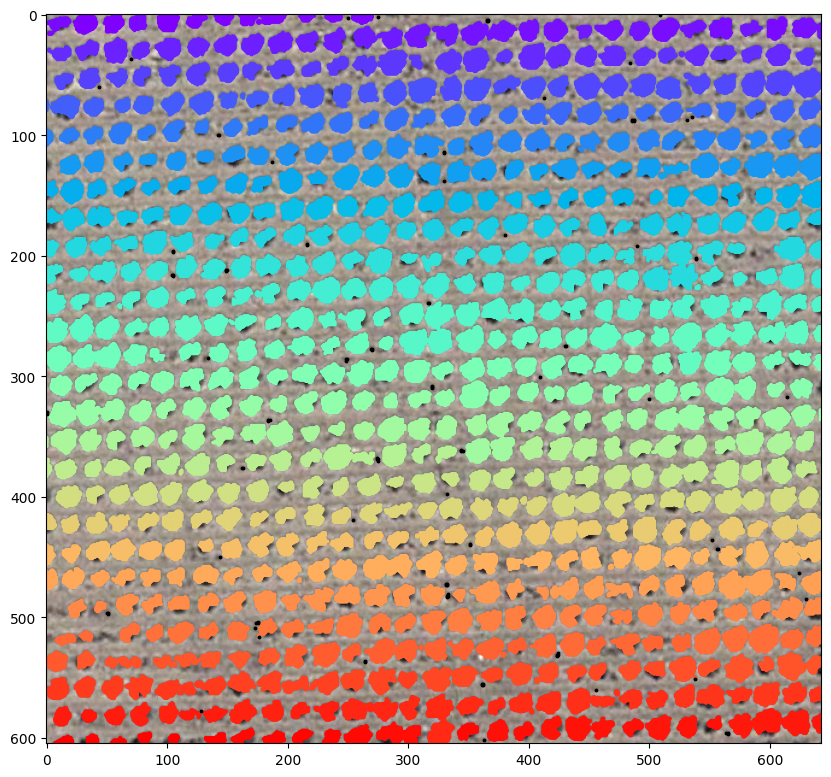

In [ ]:
from sklearn.cluster import DBSCAN
from collections import Counter
from scipy.spatial import ConvexHull

# Paso 1: Umbral para binarizar la imagen
threshold = 110
y_coords, x_coords = np.where(gray_array < threshold)
points = np.column_stack((x_coords, y_coords))

# Paso 2: Birch para agrupaciones iniciales
birch = Birch(branching_factor=10000, n_clusters=None, threshold=4.0, compute_labels=True)
birch.fit(points)

labels = birch.labels_
label_counts = Counter(labels)

# Paso 3: Filtro por número mínimo de puntos
min_points = 35
filtered_indices = [i for i, lbl in enumerate(labels) if label_counts[lbl] >= min_points]
filtered_points = points[filtered_indices]
filtered_labels = [labels[i] for i in filtered_indices]

# Paso 4: DBSCAN para limpiar aún más
dbscan = DBSCAN(eps=3, min_samples=5)  # Puedes ajustar estos valores
dbscan_labels = dbscan.fit_predict(filtered_points)

# Separar los outliers (label == -1) de los puntos válidos
core_mask = dbscan_labels != -1
core_points = filtered_points[core_mask]
core_labels = dbscan_labels[core_mask]

outliers = filtered_points[~core_mask]

# Paso 5: Visualización
plt.figure(figsize=(10, 10))
plt.imshow(image_array)
plt.scatter(core_points[:, 0], core_points[:, 1], c=core_labels, cmap='rainbow', s=3, label="Puntos válidos")
plt.scatter(outliers[:, 0], outliers[:, 1], color="black", s=3, label="Outliers")
plt.title


In [ ]:
# 6. Indicar  el número de puntos interpretados.
core_labels = np.array(core_labels)

# Eliminamos el label -1 (outliers) y contamos los únicos
n_arboles = len(set(core_labels)) - (1 if -1 in core_labels else 0)

print("Número total de árboles detectados:", n_arboles)

Número total de árboles detectados: 708


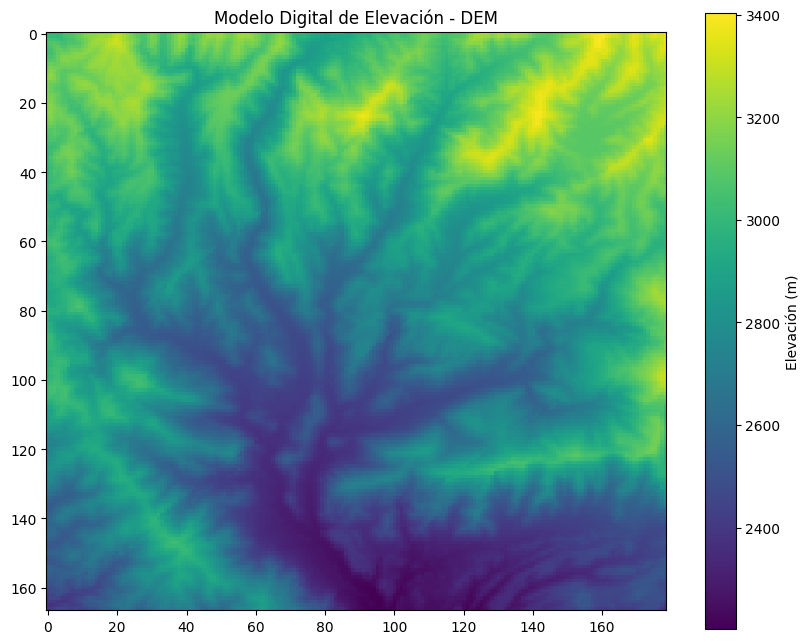

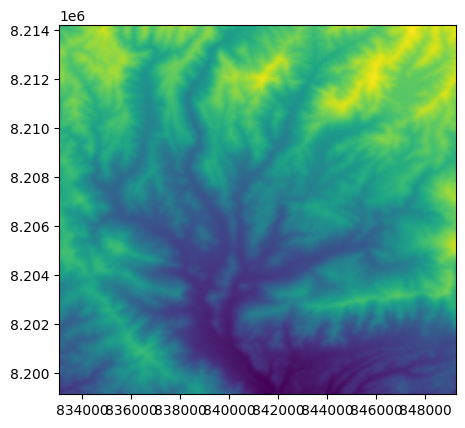

In [ ]:
# 7. Representar mediante una gráfica la evolución de suelo a escala de cuenca durante 100 mil años usando los mismo parámetros de los componentes fluviales, hillslope y uplift del ejercicio desarrollado en la Sesion 02 de Módulo 06.

# Añadir imports que no se han puesto

import sys
from rasterio.plot import show
from landlab import HexModelGrid, RasterModelGrid, imshow_grid
from landlab.components import FlowAccumulator, FastscapeEroder, DepressionFinderAndRouter, LinearDiffuser, StreamPowerEroder

# Abrir el raster
img1 = rasterio.open('./Data Examen 3/Ex_3/DEM_18S_clip.tif')

# Leer la primera banda del raster (matriz de elevaciones)
elevArray = img1.read(1)

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Mostrar el raster con un colormap
img_plot = ax.imshow(elevArray, cmap='viridis')
plt.colorbar(img_plot, ax=ax, label="Elevación (m)")

# Título
plt.title("Modelo Digital de Elevación - DEM")

# Mostrar el gráfico
plt.show()

show(img1)
plt.show()

In [ ]:
uplift_rate = 0.001  # [m/yr], initially set at 0.001  
K_sp = 1.0e-5  # units vary depending on m_sp and n_sp, initially set  at 1e-5
m_sp = 0.5  # exponent on drainage area in stream power equation,  initially 0.5  
n_sp = 1.0  # exponent on slope in stream power equation, initially 1.  
K_hs = 0.05  # [m^2/yr], initially 0.05  

167 179 90.3109901477272


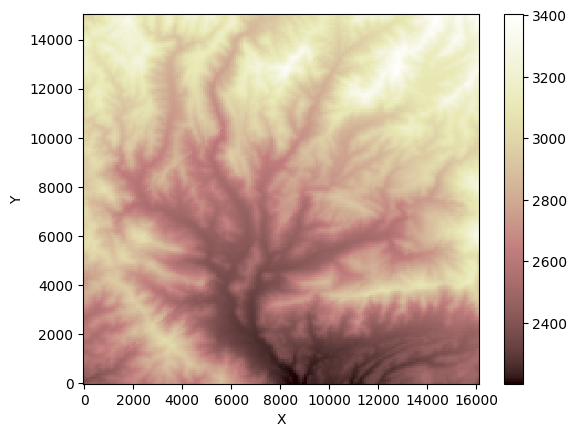

In [ ]:
# Generación de grilla a partir de atributos de raster
nrows = img1.height
ncols = img1.width
dxy = img1.transform.a

mg = RasterModelGrid(shape=(nrows, ncols), xy_spacing=dxy)
xy_lower_left = (img1.bounds.left, img1.bounds.bottom)

# show number of row, col and resolution  
print(nrows, ncols, dxy)  

dt = 1000  # time step [yr] 
total_time = 0  # amount of time the landscape has evolved [yr]  
tmax = 100000  # time for the model loop to run [yr]     
t = np.arange(0, tmax, dt)  

zr = mg.add_zeros("topographic__elevation", at="node")  # add elevation to nodes

zr += elevArray[::-1,:].ravel()  # add elevation to nodes
imshow_grid(mg, "topographic__elevation")  # show elevation

In [ ]:
# Elevaciones maximas y mínimas en estado inicial
print("Elevación mínima:", np.min(zr))
print("Elevación máxima:", np.max(zr))

Elevación mínima: 2202.0
Elevación máxima: 3403.0


In [ ]:
frr = FlowAccumulator(mg)  # create flow routing object
spr = StreamPowerEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0)  # create stream power eroder object
dfn = LinearDiffuser(mg, linear_diffusivity=K_hs, deposit=False)  # create linear diffusive transport object
df = DepressionFinderAndRouter(mg)  # create depression finder object

# Simulaión evolución del suelo a escala de cuenca
for ti in t:
  zr[mg.core_nodes] += uplift_rate * dt  # add uplift to core nodes
  dfn.run_one_step(dt)  # diffuse the landscape
  frr.run_one_step()  # route flow
  spr.run_one_step(dt)  # fluvial incision
  total_time += dt  # increment time

  print("\r" + str(total_time) + " years", end="")  # print time


100000 years

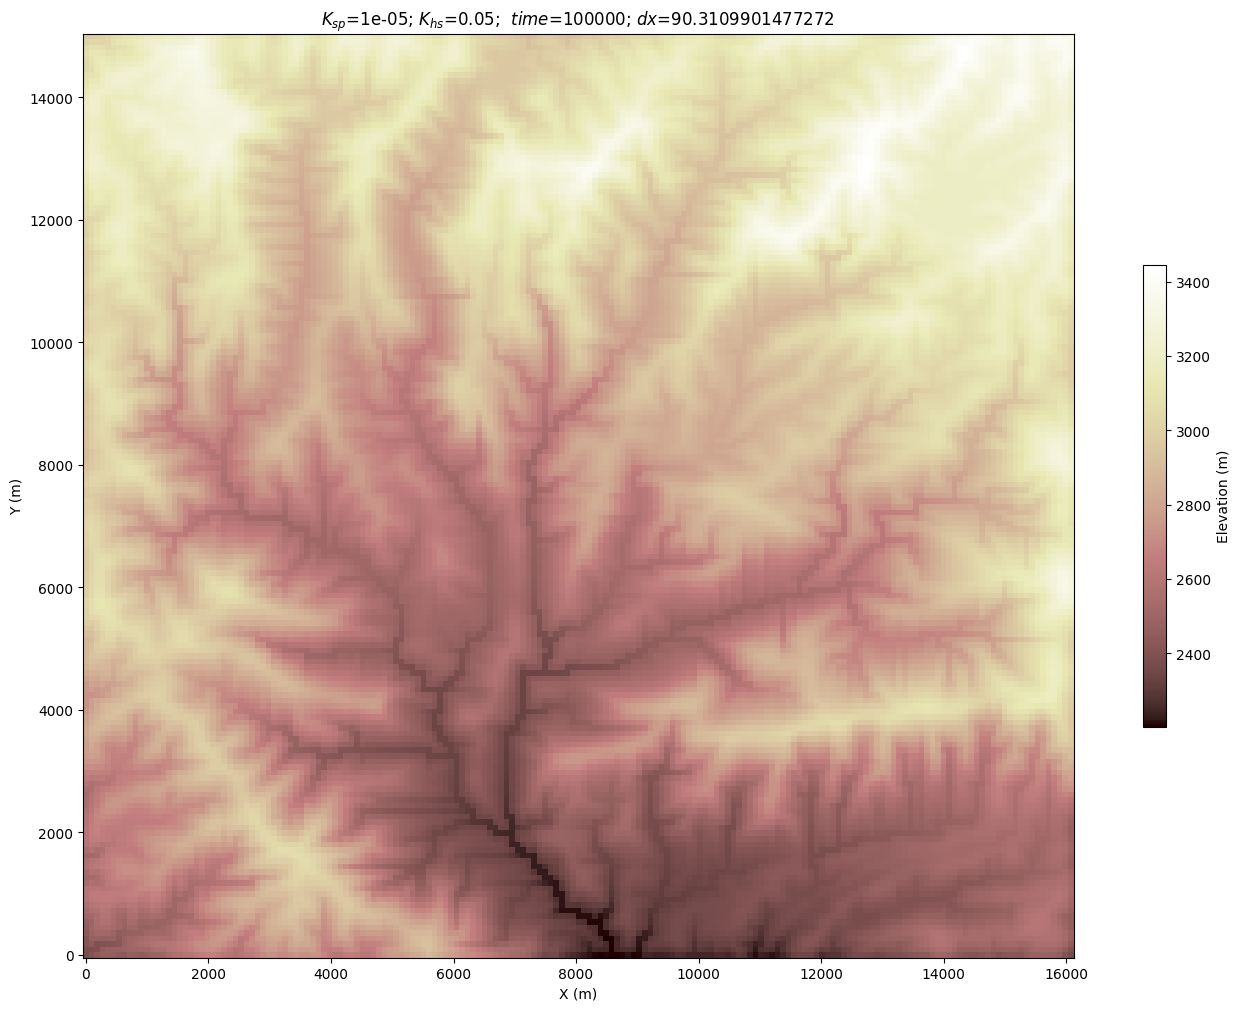

In [ ]:
# Visualización de la evolución del suelo
fig, ax = plt.subplots(figsize=(18, 12))
imshow_grid(mg, "topographic__elevation", grid_units=("m", "m"), var_name="Elevation (m)", shrink=0.5  )
title_text = f"$K_{{sp}}$={K_sp}; $K_{{hs}}$={K_hs};  $time$={total_time}; $dx$={dxy}"     
plt.title(title_text)  
plt.show()

In [ ]:
# 8. Indicar la máxima y mínima elevación del resultado.
max_elev = np.max(zr)
min_elev = np.min(zr)
print("Elevación mínima:", min_elev)
print("Elevación máxima:", max_elev)

print("Cambio de elevación máxima", elevArray.max(), "->", max_elev)
print("Cambio de elevación mínima:", elevArray.min(), "->", min_elev)

print("Diferencia de elevación anterior:", elevArray.max() - elevArray.min())
print("Diferencia de elevación posterior:", max_elev - min_elev)


Elevación mínima: 2202.0
Elevación máxima: 3446.201854400445
Cambio de elevación máxima 3403 -> 3446.201854400445
Cambio de elevación mínima: 2202 -> 2202.0
Diferencia de elevación anterior: 1201
Diferencia de elevación posterior: 1244.201854400445


In [ ]:
print("Elevación mínima:", np.min(band1))
print("Elevación máxima:", np.max(band1))


Elevación mínima: 8
Elevación máxima: 166


In [3]:
import win32com.client
RC = win32com.client.Dispatch("RAS507.HECRASController")

RC.ShowRas()

In [5]:
#Open project
RC.Project_Open(r"C:/Users/juan.guerrero/Juan/dev/apuntes/Examenes/Data Examen 3/Ex_4/Model/test02/s7.prj")

In [6]:
river=RC.Geometry_GetRivers()[1][0]
reach=RC.Geometry_GetReaches(1)[2][0]
nodes=RC.Geometry_GetNodes(1,1)[3]
nodes=list(nodes)

In [7]:
Mann_chan=round(np.random.uniform(0.06,0.08),3)
Mann_bank=round(np.random.uniform(0.06,0.08),3)
print("Mann_chan: ",Mann_chan)
print("Mann_bank: ",Mann_bank)

Mann_chan:  0.073
Mann_bank:  0.071


In [8]:
print(dir(RC))

['AddRef', 'ComputeStartedFromController', 'Compute_Cancel', 'Compute_Complete', 'Compute_CurrentPlan', 'Compute_HideComputationWindow', 'Compute_ShowComputationWindow', 'Compute_WATPlan', 'Create_WATPlanName', 'CurrentGeomFile', 'CurrentGeomHDFFile', 'CurrentPlanFile', 'CurrentProjectFile', 'CurrentProjectTitle', 'CurrentSteadyFile', 'CurrentUnSteadyFile', 'Edit_AddBC', 'Edit_AddIW', 'Edit_AddLW', 'Edit_AddXS', 'Edit_BC', 'Edit_GeometricData', 'Edit_IW', 'Edit_LW', 'Edit_MultipleRun', 'Edit_PlanData', 'Edit_QuasiUnsteadyFlowData', 'Edit_SedimentData', 'Edit_SteadyFlowData', 'Edit_UnsteadyFlowData', 'Edit_WaterQualityData', 'Edit_XS', 'ExportGIS', 'Geometery_GISImport', 'Geometry', 'Geometry_BreachParamGetXML', 'Geometry_BreachParamSetXML', 'Geometry_Get2DFlowAreas', 'Geometry_GetGML', 'Geometry_GetGateNames', 'Geometry_GetMann', 'Geometry_GetNode', 'Geometry_GetNodes', 'Geometry_GetReaches', 'Geometry_GetRivers', 'Geometry_GetStorageAreas', 'Geometry_RatioMann', 'Geometry_SetMann', 'G

In [9]:
for i in range(19):
  Var_Mann=RC.Geometry_SetMann_LChR(river,reach,nodes[i],Mann_bank,Mann_chan,Mann_bank)
  print(Var_Mann)


(True, 'River 1         ', 'Reach 1         ', '3909    ', 0.07100000232458115, 0.0729999989271164, 0.07100000232458115, '')
(True, 'River 1         ', 'Reach 1         ', '3665    ', 0.07100000232458115, 0.0729999989271164, 0.07100000232458115, '')
(True, 'River 1         ', 'Reach 1         ', '3419    ', 0.07100000232458115, 0.0729999989271164, 0.07100000232458115, '')
(True, 'River 1         ', 'Reach 1         ', '3203    ', 0.07100000232458115, 0.0729999989271164, 0.07100000232458115, '')
(True, 'River 1         ', 'Reach 1         ', '2988    ', 0.07100000232458115, 0.0729999989271164, 0.07100000232458115, '')
(True, 'River 1         ', 'Reach 1         ', '2753    ', 0.07100000232458115, 0.0729999989271164, 0.07100000232458115, '')
(True, 'River 1         ', 'Reach 1         ', '2528    ', 0.07100000232458115, 0.0729999989271164, 0.07100000232458115, '')
(True, 'River 1         ', 'Reach 1         ', '2330    ', 0.07100000232458115, 0.0729999989271164, 0.07100000232458115, '')


In [10]:
RC.Compute_CurrentPlan(None,None,True) 
# RC.Project_Save()
# RC.QuitRas() 

(True,
 3,
 ('Starting Steady Computations', 'Computing', 'Computations Completed'),
 True)

In [11]:
water_list,flow_list,veloc_list =[],[],[]  

In [12]:
for i in range(19):      
  water=RC.Output_NodeOutput(1,1,i+1,None,1,2)[0]      
  flow=RC.Output_NodeOutput(1,1,i+1,None,1,9)[0]      
  veloc=RC.Output_NodeOutput(1,1,i+1,None,1,23)[0]       
  water_list.append(water)
  flow_list.append(flow)
  veloc_list.append(veloc)  

In [13]:
water_list

[2447.566162109375,
 2447.54541015625,
 2447.5234375,
 2447.515380859375,
 2447.489501953125,
 2447.463134765625,
 2447.453857421875,
 2446.689208984375,
 2444.949951171875,
 2444.8564453125,
 2443.955810546875,
 2442.645751953125,
 2442.46240234375,
 2442.124755859375,
 2441.714599609375,
 2441.538330078125,
 2441.431396484375,
 2441.309326171875,
 2441.06640625]

In [14]:
#Display results of water elevation, flow and velocity
output={'Cross Sections':nodes,'Water Surface Elevation(m)':water_list,'Flow(m³/s)':flow_list,'Velocities(m/s)':veloc_list}
df=pd.DataFrame(output)
df.set_index('Cross Sections')
print(len(nodes), len(water_list), len(flow_list), len(veloc_list))

19 19 19 19


In [15]:
df

Cross Sections  Water Surface Elevation(m)  Flow(m³/s)  Velocities(m/s)
0        3909                     2447.566162   49.999992         0.170982
1        3665                     2447.545410   49.999992         0.342401
2        3419                     2447.523438   49.999992         0.229937
3        3203                     2447.515381   49.999992         0.155260
4        2988                     2447.489502   49.999992         0.474583
5        2753                     2447.463135   49.999992         0.240510
6        2528                     2447.453857   49.999992         0.158589
7        2330                     2446.689209   49.999992         3.640512
8        2059                     2444.949951   49.999992         0.347901
9        1857                     2444.856445   49.999992         0.485823
10       1701                     2443.955811   49.999992         3.213779
11       1534                     2442.645752   49.999992         0.455180
12       1336                     2442.462402   49.999992         0.546407
13       1155                     2442.124756   49.999992         0.748684
14       922                      2441.714600   49.999992         0.595248
15       709                      2441.538330   49.999992         0.405551
16       513                      2441.431396   49.999992         0.345754
17       339                      2441.309326   49.999992         0.463065
18       100                      2441.066406   49.999992         0.526253

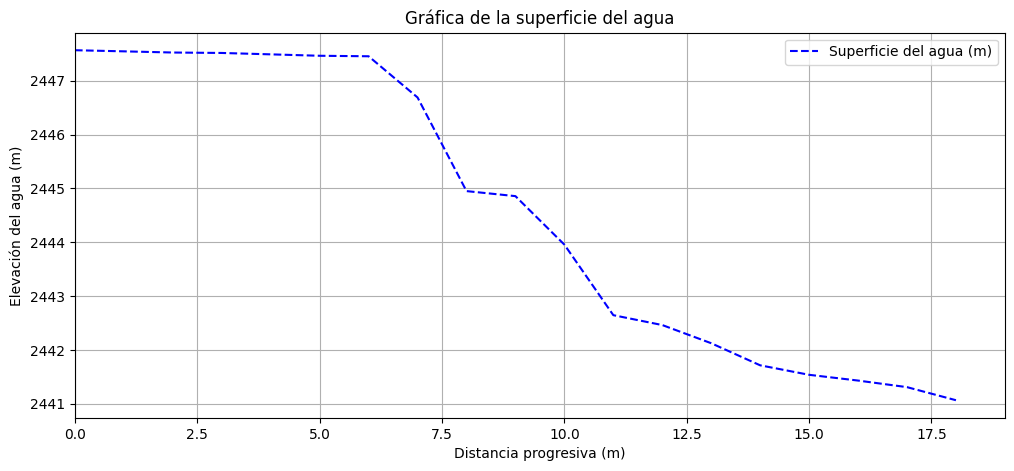

In [16]:
# 9. Obtener la gráfica de la superficie del agua.
plt.figure(figsize=(12,5))
sns.lineplot(water_list, linestyle="--", color="blue", label="Superficie del agua (m)")
plt.title("Gráfica de la superficie del agua")
plt.xlabel("Distancia progresiva (m)")
plt.ylabel("Elevación del agua (m)")
plt.xlim(0, 19)
plt.grid(True)
plt.legend(loc="best")
plt.show()

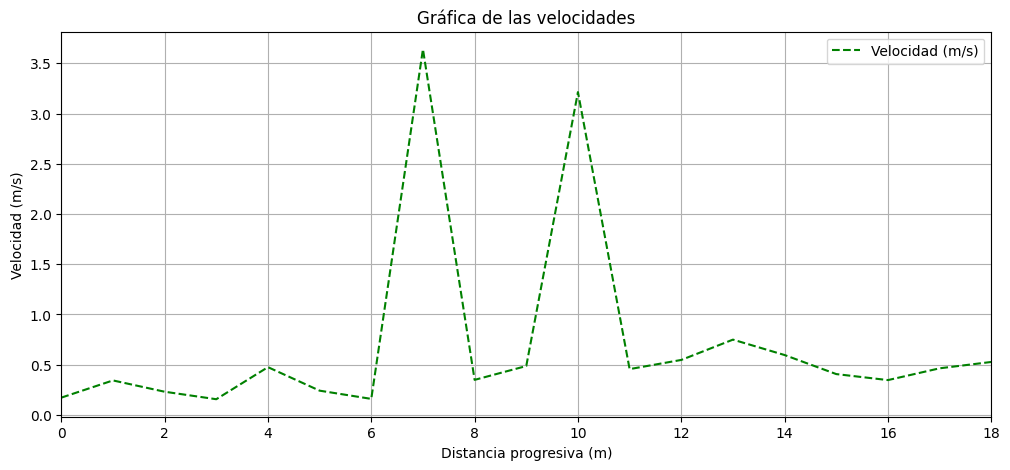

In [17]:

# 10. Obtener la gráfica de las velocidades.
plt.figure(figsize=(12,5))
sns.lineplot(veloc_list, linestyle="--", color="green", label="Velocidad (m/s)")
plt.title("Gráfica de las velocidades")
plt.xlabel("Distancia progresiva (m)")
plt.ylabel("Velocidad (m/s)")
plt.grid(True)
plt.xlim(0, 18)
plt.legend(loc="best")
plt.show()